# 1. Load And Integrate The Baseline and Longitudinal Datasets

In [36]:
import pandas as pd
import numpy as np
import os
import re

# Paths
DATA_PATH = "data/raw/"
OUT_PATH = "data/processed/"
os.makedirs(OUT_PATH, exist_ok=True)

# Helpers
def detect_column(df, patterns):
    for p in patterns:
        for c in df.columns:
            if re.search(p, c, re.I):
                return c
    return None

def normalize_subject(x):
    if pd.isna(x):
        return np.nan
    return str(x).strip()

def normalize_visit_val(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    m = re.search(r"(\\d+)", s)
    if m:
        try:
            return int(m.group(1))
        except Exception:
            return s
    return s


## 1.1 Integrate BaselineData + MCIscore_Baseline

In [37]:
# 1.1 Produce df_baseline: BaselineData + MCIscore_Baseline
print("# Producing df_baseline (BaselineData + MCIscore_Baseline)")

# Read feature and score files
baseline_feat_fp = os.path.join(DATA_PATH, 'BaselineData.xlsx')
baseline_score_fp = os.path.join(DATA_PATH, 'MCIscore_Baseline.xlsx')

if not os.path.exists(baseline_feat_fp) or not os.path.exists(baseline_score_fp):
    raise FileNotFoundError('Baseline files not found under data/raw/. Expected BaselineData.xlsx and MCIscore_Baseline.xlsx')

df_base_feat = pd.read_excel(baseline_feat_fp)
df_base_feat.columns = [str(c).strip() for c in df_base_feat.columns]

df_base_score = pd.read_excel(baseline_score_fp)
df_base_score.columns = [str(c).strip() for c in df_base_score.columns]

# Detect subject/visit columns in both
sub_col_feat = detect_column(df_base_feat, ['subject', '^id$'])
visit_col_feat = detect_column(df_base_feat, ['visit', 'timepoint', 'session'])
sub_col_score = detect_column(df_base_score, ['subject', '^id$'])
visit_col_score = detect_column(df_base_score, ['visit', 'timepoint', 'session'])

if sub_col_feat is None or visit_col_feat is None:
    raise ValueError('Could not detect SubjectNumber or Visit columns in BaselineData.xlsx')
if sub_col_score is None or visit_col_score is None:
    raise ValueError('Could not detect SubjectNumber or Visit columns in MCIscore_Baseline.xlsx')

# Rename to canonical keys
df_base_feat.rename(columns={sub_col_feat: 'SubjectNumber', visit_col_feat: 'Visit'}, inplace=True)
df_base_score.rename(columns={sub_col_score: 'SubjectNumber', visit_col_score: 'Visit'}, inplace=True)

# Normalize key values
for df in (df_base_feat, df_base_score):
    df['SubjectNumber'] = df['SubjectNumber'].apply(normalize_subject)
    df['Visit'] = df['Visit'].apply(normalize_visit_val)

# Detect MCI score column in score file
score_candidates = [c for c in df_base_score.columns if re.search('mci.*score|score.*mci|mci_score|mci', c, re.I)]
if not score_candidates:
    # fallback: numeric column
    possible = [c for c in df_base_score.columns if c not in ['SubjectNumber','Visit']]
    numeric_candidates = []
    for c in possible:
        try:
            pd.to_numeric(df_base_score[c].dropna().iloc[:10])
            numeric_candidates.append(c)
        except Exception:
            pass
    if numeric_candidates:
        mci_col_base = numeric_candidates[0]
        print(f"Warning: Using numeric column '{mci_col_base}' from baseline score as MCI score (no explicit 'mci' found).")
    else:
        raise ValueError('Could not find an MCI score column in MCIscore_Baseline.xlsx')
else:
    mci_col_base = next((c for c in score_candidates if re.search('score', c, re.I)), score_candidates[0])

# Ensure numeric
df_base_score[mci_col_base] = pd.to_numeric(df_base_score[mci_col_base], errors='coerce').astype(float)
# Aggregate (keep last non-null per SubjectNumber+Visit)
df_base_score.sort_values(['SubjectNumber','Visit'], inplace=True, kind='stable')
df_base_score['MCI_score_base'] = df_base_score[mci_col_base]
df_base_agg = df_base_score.drop_duplicates(subset=['SubjectNumber','Visit'], keep='last')[['SubjectNumber','Visit','MCI_score_base']]

# Merge into features
if set(['SubjectNumber','Visit']).issubset(df_base_feat.columns):
    df_baseline = df_base_feat.merge(df_base_agg, on=['SubjectNumber','Visit'], how='left')
else:
    raise ValueError('Baseline feature file does not contain canonical SubjectNumber and Visit after renaming')

# Print samples
display(f'Shape of df_baseline: {df_baseline.shape}')
display(df_baseline[['SubjectNumber','Visit','MCI_score_base']].head(10))


# Producing df_baseline (BaselineData + MCIscore_Baseline)


'Shape of df_baseline: (82, 622)'

,SubjectNumber,Visit,MCI_score_base
0,973,V1,-1.952523
1,966,V1,0.417247
2,964,V1,-0.239042
3,953,V1,-1.125733
4,952,V1,-1.931261
5,951,V1,-0.236375
6,950,V1,-1.331642
7,944,V1,-0.431642
8,943,V1,-3.296791
9,939,V1,-1.153903


## 1.2 Integrate LongitData + MCIscore_Longit_V1 & V2

In [38]:
# 1.2 Produce df_longit: LongitData + MCIscore_Longit_V1 & V2
print('\n# Producing df_longit (LongitData + MCIscore_Longit_V1/V2)')

longit_feat_fp = os.path.join(DATA_PATH, 'LongitData.xlsx')
v1_fp = os.path.join(DATA_PATH, 'MCIscore_Longit_V1.xlsx')
v2_fp = os.path.join(DATA_PATH, 'MCIscore_Longit_V2.xlsx')

for p in (longit_feat_fp, v1_fp, v2_fp):
    if not os.path.exists(p):
        raise FileNotFoundError(f'Missing required longit file: {p}')

# Read
df_longit_feat = pd.read_excel(longit_feat_fp)
df_longit_feat.columns = [str(c).strip() for c in df_longit_feat.columns]

df_v1 = pd.read_excel(v1_fp)
df_v1.columns = [str(c).strip() for c in df_v1.columns]

df_v2 = pd.read_excel(v2_fp)
df_v2.columns = [str(c).strip() for c in df_v2.columns]

# Detect and rename keys in each
for df, name in [(df_longit_feat, 'features'), (df_v1, 'v1'), (df_v2, 'v2')]:
    sub_col = detect_column(df, ['subject', '^id$'])
    visit_col = detect_column(df, ['visit', 'timepoint', 'session'])
    if sub_col is None or visit_col is None:
        raise ValueError(f'Could not detect keys in {name} longit file')
    df.rename(columns={sub_col: 'SubjectNumber', visit_col: 'Visit'}, inplace=True)
    df['SubjectNumber'] = df['SubjectNumber'].apply(normalize_subject)
    df['Visit'] = df['Visit'].apply(normalize_visit_val)

# Detect score columns in v1 and v2
def detect_mci_col(df):
    candidates = [c for c in df.columns if re.search('mci.*score|score.*mci|mci_score|mci', c, re.I)]
    if candidates:
        return next((c for c in candidates if re.search('score', c, re.I)), candidates[0])
    # fallback numeric
    possible = [c for c in df.columns if c not in ['SubjectNumber','Visit']]
    for c in possible:
        try:
            pd.to_numeric(df[c].dropna().iloc[:10])
            return c
        except Exception:
            pass
    return None

mci_v1_col = detect_mci_col(df_v1)
mci_v2_col = detect_mci_col(df_v2)
if mci_v1_col is None and mci_v2_col is None:
    raise ValueError('No MCI score columns found in both longit V1 and V2 files')

# Ensure numeric and force float dtype
if mci_v1_col:
    df_v1[mci_v1_col] = pd.to_numeric(df_v1[mci_v1_col], errors='coerce').astype(float)
    df_v1['MCI_score_v1'] = df_v1[mci_v1_col].astype(float)
    df_v1.sort_values(['SubjectNumber','Visit'], inplace=True, kind='stable')
    df_v1_agg = df_v1.drop_duplicates(subset=['SubjectNumber','Visit'], keep='last')[['SubjectNumber','Visit','MCI_score_v1']]
else:
    df_v1_agg = pd.DataFrame(columns=['SubjectNumber','Visit','MCI_score_v1'])

if mci_v2_col:
    df_v2[mci_v2_col] = pd.to_numeric(df_v2[mci_v2_col], errors='coerce')
    df_v2['MCI_score_v2'] = df_v2[mci_v2_col]
    df_v2.sort_values(['SubjectNumber','Visit'], inplace=True, kind='stable')
    df_v2_agg = df_v2.drop_duplicates(subset=['SubjectNumber','Visit'], keep='last')[['SubjectNumber','Visit','MCI_score_v2']]
else:
    df_v2_agg = pd.DataFrame(columns=['SubjectNumber','Visit','MCI_score_v2'])

# Merge aggregates into longit features
if set(['SubjectNumber','Visit']).issubset(df_longit_feat.columns):
    df_longit = df_longit_feat.merge(df_v1_agg, on=['SubjectNumber','Visit'], how='left')
    df_longit = df_longit.merge(df_v2_agg, on=['SubjectNumber','Visit'], how='left')
else:
    raise ValueError('LongitData features did not contain canonical SubjectNumber and Visit after renaming')

display(f'Shape of df_longit: {df_longit.shape}')
display(df_longit[['SubjectNumber','Visit'] + [c for c in ['MCI_score_v1','MCI_score_v2'] if c in df_longit.columns]].head(10))


# Producing df_longit (LongitData + MCIscore_Longit_V1/V2)


'Shape of df_longit: (94, 659)'

,SubjectNumber,Visit,MCI_score_v1,MCI_score_v2
0,966,V1,0.417247,NaN
1,966,V2,NaN,0.099258
2,964,V1,-0.239042,NaN
3,964,V2,NaN,2.604952
4,953,V1,-1.125733,NaN
5,953,V2,NaN,-0.036153
6,951,V1,-0.236375,NaN
7,951,V2,NaN,1.496596
8,950,V1,-1.331642,NaN
9,950,V2,NaN,-1.483921


## 1.3 Integration Results: Subjects' Visit Report

As a result of the dataset analysis, it was found that only **47 out of 82 subjects** in the `Baseline.xlsx` dataset returned for the **second EEG recording**, and their **MCI scores** were calculated.  
The remaining **35 subjects** participated in the EEG recording **only once**.  
This explains why there are **94 records** in Longitudinal Data — calculated as `47*2 = 94` — instead of the **expected 162 rows** (`82*2 = 162`) in the `df_longit` dataframe.


# 2. Creating a Binary Diagnosis Attribute & Optimal Threshold Estimation Based on Condition-Labeled Binary Diagnosis

## 2.1 Creating a Binary Diagnosis Attribute Based on Condition Attribute

In [39]:
print("\n# 2.1 Creating Binary Diagnosis Columns Based on Condition and Visit")

import numpy as np
import pandas as pd

# Ensure required DataFrames exist
missing = [n for n in ('df_baseline', 'df_longit') if n not in globals()]
if missing:
    raise RuntimeError(f"Missing required DataFrame(s): {', '.join(missing)}")

# BASELINE
df_baseline = globals()['df_baseline']
if 'Condition' not in df_baseline.columns:
    raise ValueError("df_baseline must contain a 'Condition' column.")

# Map Condition -> Diagnosis_base (HC→0, MCI→1)
df_baseline['Diagnosis_base'] = df_baseline['Condition'].astype(str).str.upper().map({'HC': 0, 'MCI': 1}).astype('float')
print(f"Baseline: created Diagnosis_base (non-null: {int(df_baseline['Diagnosis_base'].notna().sum())})")

# LONGITUDINAL
df_longit = globals()['df_longit']
if not {'Condition', 'Visit'}.issubset(df_longit.columns):
    raise ValueError("df_longit must contain 'Condition' and 'Visit' columns.")

# Version-based binary labels
df_longit['Diagnosis_v1'] = np.where(
    df_longit['Visit'].astype(str).str.contains('1', regex=False),
    df_longit['Condition'].astype(str).str.upper().map({'HC': 0, 'MCI': 1}),
    np.nan
)
df_longit['Diagnosis_v2'] = np.where(
    df_longit['Visit'].astype(str).str.contains('2', regex=False),
    df_longit['Condition'].astype(str).str.upper().map({'HC': 0, 'MCI': 1}),
    np.nan
)
print(f"Longitudinal: created Diagnosis_v1 and Diagnosis_v2 using Condition + Visit (non-nulls: {int(df_longit['Diagnosis_v1'].notna().sum())}, {int(df_longit['Diagnosis_v2'].notna().sum())})")

# Display
print("\nBaseline sample:")
cols_base = ['SubjectNumber', 'Visit', 'Condition', 'MCI_score_base', 'Diagnosis_base']
display(df_baseline[cols_base])

print("\nLongitudinal sample:")
cols_long = ['SubjectNumber', 'Visit', 'Condition',
             'MCI_score_v1', 'MCI_score_v2',
             'Diagnosis_v1', 'Diagnosis_v2']
display(df_longit[cols_long].head(12))

print("\nDone. Binary diagnosis columns successfully created from Condition and Visit.")



# 2.1 Creating Binary Diagnosis Columns Based on Condition and Visit
Baseline: created Diagnosis_base (non-null: 82)
Longitudinal: created Diagnosis_v1 and Diagnosis_v2 using Condition + Visit (non-nulls: 47, 47)

Baseline sample:


,SubjectNumber,Visit,Condition,MCI_score_base,Diagnosis_base
0,973,V1,HC,-1.952523,0.0
1,966,V1,HC,0.417247,0.0
2,964,V1,HC,-0.239042,0.0
3,953,V1,HC,-1.125733,0.0
4,952,V1,HC,-1.931261,0.0
...,...,...,...,...,...
77,354,V1,HC,-0.642293,0.0
78,353,V1,MCI,0.003706,1.0
79,199,V1,MCI,1.000330,1.0
80,195,V1,MCI,2.267420,1.0



Longitudinal sample:


,SubjectNumber,Visit,Condition,MCI_score_v1,MCI_score_v2,Diagnosis_v1,Diagnosis_v2
0,966,V1,HC,0.417247,NaN,0.0,NaN
1,966,V2,HC,NaN,0.099258,NaN,0.0
2,964,V1,HC,-0.239042,NaN,0.0,NaN
3,964,V2,HC,NaN,2.604952,NaN,0.0
4,953,V1,HC,-1.125733,NaN,0.0,NaN
5,953,V2,HC,NaN,-0.036153,NaN,0.0
6,951,V1,HC,-0.236375,NaN,0.0,NaN
7,951,V2,HC,NaN,1.496596,NaN,0.0
8,950,V1,HC,-1.331642,NaN,0.0,NaN
9,950,V2,HC,NaN,-1.483921,NaN,0.0



Done. Binary diagnosis columns successfully created from Condition and Visit.


## 2.2 Detailed Summary of Diagnosis Distributions

In [40]:
print("\n# 2.2 Detailed Summary of Diagnosis Distributions (Baseline & Longitudinal)")

# Baseline
print("\nBaseline diagnosis distribution by Condition:")
base_summary = (
    df_baseline.groupby(['Condition', 'Diagnosis_base'])
    .size()
    .reset_index(name='Count')
)
print(base_summary)

# Count totals
baseline_hc = int((df_baseline['Diagnosis_base'] == 0).sum())
baseline_mci = int((df_baseline['Diagnosis_base'] == 1).sum())
baseline_total = baseline_hc + baseline_mci

# Longitudinal
print("\nLongitudinal diagnosis distribution by Condition and Visit:")
long_summary = (
    df_longit.groupby(['Condition', 'Visit'])
    [['Diagnosis_v1', 'Diagnosis_v2']]
    .agg(lambda x: x.notna().sum())
    .reset_index()
)
print(long_summary)

# Combine both diagnosis columns for total label counts
long_all = pd.concat([df_longit['Diagnosis_v1'], df_longit['Diagnosis_v2']], ignore_index=True)
long_hc = int((long_all == 0).sum())
long_mci = int((long_all == 1).sum())
long_total = long_hc + long_mci

# Total Summary
print("\nDiagnosis totals:")
summary_df = pd.DataFrame({
    'Dataset': ['Baseline', 'Longitudinal', 'Combined'],
    'HC (0)': [baseline_hc, long_hc, baseline_hc + long_hc],
    'MCI (1)': [baseline_mci, long_mci, baseline_mci + long_mci],
    'Total': [baseline_total, long_total, baseline_total + long_total]
})
print(summary_df)

# Text Summary
hc_total = baseline_hc + long_hc
mci_total = baseline_mci + long_mci
grand_total = hc_total + mci_total
hc_ratio = hc_total / grand_total * 100 if grand_total > 0 else 0
mci_ratio = mci_total / grand_total * 100 if grand_total > 0 else 0

print("\nSummary Interpretation:")
print(f"In the combined dataset, a total of {grand_total} labeled samples were identified.")
print(f"Of these, {hc_total} ({hc_ratio:.1f}%) belong to the Healthy Control (HC) group, "
      f"and {mci_total} ({mci_ratio:.1f}%) belong to the Mild Cognitive Impairment (MCI) group.")
print(f"The baseline subset contains {baseline_total} labeled subjects "
      f"({baseline_hc} HC / {baseline_mci} MCI), while the longitudinal subset contributes "
      f"{long_total} labeled instances ({long_hc} HC / {long_mci} MCI) across visits.")



# 2.2 Detailed Summary of Diagnosis Distributions (Baseline & Longitudinal)

Baseline diagnosis distribution by Condition:
  Condition  Diagnosis_base  Count
0        HC             0.0     44
1       MCI             1.0     38

Longitudinal diagnosis distribution by Condition and Visit:
  Condition Visit  Diagnosis_v1  Diagnosis_v2
0        HC    V1            29             0
1        HC    V2             0            31
2       MCI    V1            18             0
3       MCI    V2             0            16

Diagnosis totals:
        Dataset  HC (0)  MCI (1)  Total
0      Baseline      44       38     82
1  Longitudinal      60       34     94
2      Combined     104       72    176

Summary Interpretation:
In the combined dataset, a total of 176 labeled samples were identified.
Of these, 104 (59.1%) belong to the Healthy Control (HC) group, and 72 (40.9%) belong to the Mild Cognitive Impairment (MCI) group.
The baseline subset contains 82 labeled subjects (44 HC / 38 MCI), whil

## 2.3 Combine BaseLine &  Datasets to Estimate The Empirical Threshold (vs. Expected Threshold 0.0)

In [41]:
# --- Combine both datasets to estimate the empirical threshold using scikit-learn metrics ---
print('\n# 2.3 Combine Baseline & Longitudinal Datasets to Estimate the Empirical Threshold (vs. Expected Threshold 0.0)')

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

expected_threshold = 0.0  # reference only, not used for classification

pairs = []

# Baseline
if {'MCI_score_base', 'Diagnosis_base'}.issubset(df_baseline.columns):
    tmp = df_baseline[['MCI_score_base', 'Diagnosis_base']].dropna().rename(columns={'MCI_score_base': 'score', 'Diagnosis_base': 'label'})
    if not tmp.empty:
        pairs.append(tmp)
    print(f"Baseline pairs added: {len(tmp)}")
else:
    print("Baseline missing required columns — skipped.")

# Longitudinal
if {'MCI_score_v1', 'Diagnosis_v1'}.issubset(df_longit.columns):
    tmp_v1 = df_longit[['MCI_score_v1', 'Diagnosis_v1']].dropna().rename(columns={'MCI_score_v1': 'score', 'Diagnosis_v1': 'label'})
    if not tmp_v1.empty:
        pairs.append(tmp_v1)
    print(f"Longitudinal V1 pairs added: {len(tmp_v1)}")
else:
    print("Longitudinal V1 missing required columns — skipped.")

if {'MCI_score_v2', 'Diagnosis_v2'}.issubset(df_longit.columns):
    tmp_v2 = df_longit[['MCI_score_v2', 'Diagnosis_v2']].dropna().rename(columns={'MCI_score_v2': 'score', 'Diagnosis_v2': 'label'})
    if not tmp_v2.empty:
        pairs.append(tmp_v2)
    print(f"Longitudinal V2 pairs added: {len(tmp_v2)}")
else:
    print("Longitudinal V2 missing required columns — skipped.")

# Threshold estimation
if not pairs:
    print('\nNo (score, label) pairs found — cannot estimate empirical threshold.')
else:
    df_pairs = pd.concat(pairs, ignore_index=True).dropna()
    df_pairs['label'] = df_pairs['label'].astype(int)
    scores = df_pairs['score'].values
    labels = df_pairs['label'].values

    uniq = np.unique(scores)
    if len(uniq) == 1:
        candidates = uniq
    else:
        candidates = (uniq[:-1] + uniq[1:]) / 2.0

    best_t, best_acc, best_f1 = None, -1.0, -1.0

    for t in candidates:
        preds = (scores > t).astype(int)
        acc = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds, zero_division=0)
        if (acc > best_acc) or (acc == best_acc and f1 > best_f1):
            best_t, best_acc, best_f1 = t, acc, f1

    print(f"\nFound {len(df_pairs)} labeled (score, label) pairs.")
    print(f"Empirical best threshold (max accuracy, tie-broken by F1): {best_t:.6f}")
    print(f"→ Accuracy: {best_acc:.3%}, F1: {best_f1:.3f}")

    smin, smax = float(scores.min()), float(scores.max())
    abs_diff = abs(best_t - expected_threshold)
    pct_of_range = (abs_diff / (smax - smin) * 100.0) if smax > smin else float('nan')

    print(f"\nExpected threshold (reference): {expected_threshold:.6f}")
    print(f"Difference from empirical threshold: {abs_diff:.6f} ({pct_of_range:.2f}% of score range)")
    print(f"Observed score range: [{smin:.6f}, {smax:.6f}]")

    # Confusion matrices for comparison
    try:
        cm_expected = confusion_matrix(labels, (scores > expected_threshold).astype(int))
        cm_best = confusion_matrix(labels, (scores > best_t).astype(int))
        print('\nConfusion matrix @ expected threshold:')
        print(cm_expected)
        print('\nConfusion matrix @ empirical threshold:')
        print(cm_best)
    except Exception as e:
        print(f"Could not compute confusion matrices: {e}")



# 2.3 Combine Baseline & Longitudinal Datasets to Estimate the Empirical Threshold (vs. Expected Threshold 0.0)
Baseline pairs added: 82
Longitudinal V1 pairs added: 47
Longitudinal V2 pairs added: 47

Found 176 labeled (score, label) pairs.
Empirical best threshold (max accuracy, tie-broken by F1): 0.237787
→ Accuracy: 80.682%, F1: 0.782

Expected threshold (reference): 0.000000
Difference from empirical threshold: 0.237787 (2.97% of score range)
Observed score range: [-4.630192, 3.386646]

Confusion matrix @ expected threshold:
[[74 30]
 [ 7 65]]

Confusion matrix @ empirical threshold:
[[81 23]
 [11 61]]


## 2.4 Threshold Discussion (Empirical vs. Expected Threshold = 0.0)
In the original study, the classification threshold for differentiating MCI and HC subjects was reported as **0.0**. However, when applied to the present dataset, this predefined threshold led to suboptimal classification performance. Therefore, the empirical threshold was recalculated by comparing the MCI scores with the binary diagnosis labels derived from the dataset’s `Condition` attribute.

As a result, the most optimal threshold — determined using scikit-learn accuracy and F1 metrics — was found to be **0.2378** based on 176 labeled score pairs. This threshold achieved an **accuracy of 80.68%** and an **F1-score of 0.782**, representing a measurable improvement over the expected threshold of 0.0 (accuracy ≈ 78.99%, F1 ≈ 0.778). The difference corresponds to **2.97%** of the observed score range ([-4.63, 3.39]), indicating a small but meaningful shift in the decision boundary.

The confusion matrices below summarize the classification results at both thresholds:

| Threshold          | TN | FP | FN | TP | Accuracy | F1-score |
| ------------------ | -- | -- | -- | -- | -------- | -------- |
| 0.0 (expected)     | 74 | 30 | 7  | 65 | 78.99%   | 0.778    |
| 0.2378 (empirical) | 81 | 23 | 11 | 61 | 80.68%   | 0.782    |

These findings suggest that, although the difference from the originally defined threshold is modest, applying the empirically derived threshold provides a more balanced classification between healthy controls and MCI subjects, leading to slightly improved diagnostic reliability.


# 3. Progression Analysis: Add MCI Scores Difference and Progression Attribute to Longitudinal Data

This section computes the difference between follow-up and baseline MCI scores in the longitudinal dataset, and derives a simple progression attribute to indicate whether the subject's MCI score has increased, decreased, or remained stable.

In [42]:
print("\n# 3 Progression Analysis: Computing MCI score difference and progression attribute to Longitudinal Data")

import numpy as np
import pandas as pd

# Configuration
v1_col = 'MCI_score_v1'
v2_col = 'MCI_score_v2'
diff_col = 'MCI_score_diff'
prog_col = 'MCI_progression'
change_tol = 0.01  # difference threshold (tolerance)

# Check prerequisites
missing_cols = [c for c in (v1_col, v2_col) if c not in df_longit.columns]
if missing_cols:
    raise ValueError(f"df_longit is missing required column(s): {', '.join(missing_cols)}")

# Ensure numeric
df_longit[v1_col] = pd.to_numeric(df_longit[v1_col], errors='coerce')
df_longit[v2_col] = pd.to_numeric(df_longit[v2_col], errors='coerce')

print(df_longit.columns.tolist())
df_longit.info()



# 3 Progression Analysis: Computing MCI score difference and progression attribute to Longitudinal Data
['SubjectNumber', 'Visit', 'ABM_stage', 'Age_V2', 'Age_V3', 'CVT_LPP_C3', 'CVT_LPP_C4', 'CVT_LPP_Cz', 'CVT_LPP_F3', 'CVT_LPP_F4', 'CVT_LPP_F7', 'CVT_LPP_F8', 'CVT_LPP_Fp1', 'CVT_LPP_Fp2', 'CVT_LPP_Fz', 'CVT_LPP_O1', 'CVT_LPP_O2', 'CVT_LPP_P3', 'CVT_LPP_P4', 'CVT_LPP_POz', 'CVT_LPP_Pz', 'CVT_LPP_T3', 'CVT_LPP_T4', 'CVT_LPP_T5', 'CVT_LPP_T6', 'CVT_LPPmaxLoc_C3', 'CVT_LPPmaxLoc_C4', 'CVT_LPPmaxLoc_Cz', 'CVT_LPPmaxLoc_F3', 'CVT_LPPmaxLoc_F4', 'CVT_LPPmaxLoc_F7', 'CVT_LPPmaxLoc_F8', 'CVT_LPPmaxLoc_Fp1', 'CVT_LPPmaxLoc_Fp2', 'CVT_LPPmaxLoc_Fz', 'CVT_LPPmaxLoc_O1', 'CVT_LPPmaxLoc_O2', 'CVT_LPPmaxLoc_P3', 'CVT_LPPmaxLoc_P4', 'CVT_LPPmaxLoc_POz', 'CVT_LPPmaxLoc_Pz', 'CVT_LPPmaxLoc_T3', 'CVT_LPPmaxLoc_T4', 'CVT_LPPmaxLoc_T5', 'CVT_LPPmaxLoc_T6', 'CVT_N1minLoc_C3', 'CVT_N1minLoc_C4', 'CVT_N1minLoc_Cz', 'CVT_N1minLoc_F3', 'CVT_N1minLoc_F4', 'CVT_N1minLoc_F7', 'CVT_N1minLoc_F8', 'CVT_N1minLoc_Fp

## 3.1 Difference Calculation

- Columns used:
  - `MCI_score_v1` (baseline / earlier visit)
  - `MCI_score_v2` (follow-up / later visit)
- New column added:
  - `MCI_score_diff = MCI_score_v2 - MCI_score_v1` (NaN when either score is missing)

In [43]:
# 3.1 Difference Calculation (aligned by SubjectNumber)
print("\n# 3.1 Difference Calculation: Aligning by SubjectNumber and computing MCI_score_diff = MCI_score_v2 - MCI_score_v1")

# Ensure numeric columns (force float)
df_longit[v1_col] = pd.to_numeric(df_longit[v1_col], errors='coerce').astype(float)
df_longit[v2_col] = pd.to_numeric(df_longit[v2_col], errors='coerce').astype(float)

# Filter out NaNs
v1_df = df_longit.loc[df_longit[v1_col].notna(), ['SubjectNumber', v1_col]].drop_duplicates(subset=['SubjectNumber'], keep='last')
v2_df = df_longit.loc[df_longit[v2_col].notna(), ['SubjectNumber', v2_col]].drop_duplicates(subset=['SubjectNumber'], keep='last')

# Merge on SubjectNumber to align visits
merged_scores = pd.merge(v1_df, v2_df, on='SubjectNumber', how='inner')
merged_scores[diff_col] = merged_scores[v2_col] - merged_scores[v1_col]

print(f"\nAligned subjects: {len(merged_scores)} (with both V1 & V2 non-null)")
print(f"Mean ΔMCI_score: {merged_scores[diff_col].mean():.4f}  |  Std: {merged_scores[diff_col].std():.4f}")

# Map the computed difference back to df_longit
diff_map = merged_scores.set_index('SubjectNumber')[diff_col].to_dict()
df_longit[diff_col] = df_longit['SubjectNumber'].map(diff_map)

# Display non-null differences
print("\nSample of computed differences (non-null only):")
cols_diff = ['SubjectNumber', 'Visit', v1_col, v2_col, diff_col]
try:
    display(df_longit.loc[df_longit[diff_col].notna(), cols_diff].head(15))
except Exception:
    print(df_longit.loc[df_longit[diff_col].notna(), cols_diff].head(15).to_string(index=False))

# Basic stats of difference
print("\nDifference statistics:")
print(df_longit[diff_col].describe().to_string())



# 3.1 Difference Calculation: Aligning by SubjectNumber and computing MCI_score_diff = MCI_score_v2 - MCI_score_v1

Aligned subjects: 47 (with both V1 & V2 non-null)
Mean ΔMCI_score: -0.1074  |  Std: 1.1824

Sample of computed differences (non-null only):


,SubjectNumber,Visit,MCI_score_v1,MCI_score_v2,MCI_score_diff
0,966,V1,0.417247,NaN,-0.317989
1,966,V2,NaN,0.099258,-0.317989
2,964,V1,-0.239042,NaN,2.843994
3,964,V2,NaN,2.604952,2.843994
4,953,V1,-1.125733,NaN,1.089580
5,953,V2,NaN,-0.036153,1.089580
6,951,V1,-0.236375,NaN,1.732970
7,951,V2,NaN,1.496596,1.732970
8,950,V1,-1.331642,NaN,-0.152279
9,950,V2,NaN,-1.483921,-0.152279



Difference statistics:
count    94.000000
mean     -0.107374
std       1.176054
min      -2.910165
25%      -0.954133
50%      -0.060484
75%       0.605157
max       2.843994


# 3.2 Progression Attribute: Comparative Discussion

* In this section, two complementary progression definitions were applied:

### 3.2.1 Progression Attribute (Δ-based): Mapping MCI_score_diff into progression classes

- Computed directly from the numeric difference between visits:
    - `MCI_score_diff = MCI_score_v2 - MCI_score_v1`

- A tolerance of **±0.01** was used to classify small fluctuations as stable.
    - Values above this range indicate progression, while decreases beyond the threshold indicate regression/improvement.

- New columns added:
  - `MCI_progression` (numeric): encoded as 
  `1` = progression (score increased), `0` = stable (change within tolerance), `-1` = regression/improvement (score decreased).
  - `MCI_progression_label` (readable): textual labels: `progression`, `stable`, `regression/improvement`.

- Rule (default):
  - If `MCI_score_diff > +change_tol` → `MCI_progression = 1`
  - If `MCI_score_diff < -change_tol` → `MCI_progression = -1`
  - If `|MCI_score_diff| <= change_tol` → `MCI_progression = 0`

In [48]:
print("\n# 3.2.1 Progression Attribute (Δ-based): Mapping MCI_score_diff into progression classes")

# Compute progression categories: -1 (regression), 0 (stable), 1 (progression)
def compute_progression(delta, tol=change_tol):
    if pd.isna(delta):
        return np.nan
    if delta > tol:
        return 1
    if delta < -tol:
        return -1
    return 0

df_longit[prog_col] = df_longit[diff_col].apply(lambda x: compute_progression(x, change_tol)).astype('float')

# Readable label version
df_longit[prog_col + '_label'] = df_longit[prog_col].map({
    1: 'progression',
    0: 'stable',
    -1: 'regression/improvement'
})

# Display sample
print("\nSample rows with Δ-based progression classification:")
cols_prog = ['SubjectNumber', 'Visit', v1_col, v2_col, diff_col, prog_col, prog_col + '_label']
display(df_longit.loc[df_longit[diff_col].notna(), cols_prog].head(15))



# 3.2.1 Progression Attribute (Δ-based): Mapping MCI_score_diff into progression classes

Sample rows with Δ-based progression classification:


,SubjectNumber,Visit,MCI_score_v1,MCI_score_v2,MCI_score_diff,MCI_progression,MCI_progression_label
0,966,V1,0.417247,NaN,-0.317989,-1.0,regression/improvement
1,966,V2,NaN,0.099258,-0.317989,-1.0,regression/improvement
2,964,V1,-0.239042,NaN,2.843994,1.0,progression
3,964,V2,NaN,2.604952,2.843994,1.0,progression
4,953,V1,-1.125733,NaN,1.089580,1.0,progression
5,953,V2,NaN,-0.036153,1.089580,1.0,progression
6,951,V1,-0.236375,NaN,1.732970,1.0,progression
7,951,V2,NaN,1.496596,1.732970,1.0,progression
8,950,V1,-1.331642,NaN,-0.152279,-1.0,regression/improvement
9,950,V2,NaN,-1.483921,-0.152279,-1.0,regression/improvement


### 3.2.2 Diagnostic Progression Analysis (Threshold-based)

* Based on the empirical cutoff `0.237787`, which separates cognitively healthy and impaired subjects.
* For each subject:

  * If MCI_score crossed the threshold upward (0→1), it was labeled **progression**.
  * If it crossed downward (1→0), it was labeled **regression/improvement**.
  * Otherwise, **stable**.


In [49]:
print("\n# 3.2.2 Diagnostic Progression Analysis (Threshold-based)")

empirical_threshold = 0.237787  # from prior model

# Diagnostic classification for each visit
df_longit['MCI_diag_v1'] = np.where(df_longit['MCI_score_v1'] > empirical_threshold, 1, 0)
df_longit['MCI_diag_v2'] = np.where(df_longit['MCI_score_v2'] > empirical_threshold, 1, 0)

# Define diagnostic progression states
def compute_diagnostic_progression(v1, v2):
    if pd.isna(v1) or pd.isna(v2):
        return np.nan
    if v1 == 0 and v2 == 1:
        return 1
    if v1 == 1 and v2 == 0:
        return -1
    return 0

df_longit['MCI_progression_diag'] = df_longit.apply(
    lambda r: compute_diagnostic_progression(r['MCI_diag_v1'], r['MCI_diag_v2']), axis=1
)

print("\nSample rows with threshold-based diagnostic progression:")
display(df_longit[['SubjectNumber','MCI_score_v1','MCI_score_v2',
                   'MCI_diag_v1','MCI_diag_v2','MCI_progression_diag']].head(15))



# 3.2.2 Diagnostic Progression Analysis (Threshold-based)

Sample rows with threshold-based diagnostic progression:


,SubjectNumber,MCI_score_v1,MCI_score_v2,MCI_diag_v1,MCI_diag_v2,MCI_progression_diag
0,966,0.417247,NaN,1,0,-1
1,966,NaN,0.099258,0,0,0
2,964,-0.239042,NaN,0,0,0
3,964,NaN,2.604952,0,1,1
4,953,-1.125733,NaN,0,0,0
5,953,NaN,-0.036153,0,0,0
6,951,-0.236375,NaN,0,0,0
7,951,NaN,1.496596,0,1,1
8,950,-1.331642,NaN,0,0,0
9,950,NaN,-1.483921,0,0,0


### 3.2.3 Comparison between Δ-based and Threshold-based Progression

The two approaches were compared for consistency:

| Δ-based Progression | Threshold-based Progression | Count |
| ------------------- | --------------------------- | ----- |
| progression (1)     | progression (1)             | *n₁*  |
| regression (-1)     | regression (-1)             | *n₂*  |
| stable (0)          | stable (0)                  | *n₃*  |
| ...                 | ...                         | ...   |

Overall agreement rate between the two methods: **≈ 29.8%**.


# 3.2.3 Comparison between Δ-based and Threshold-based Progression


,MCI_progression,MCI_progression_diag,Count
0,-1.0,-1,15
1,-1.0,0,26
2,-1.0,1,9
3,1.0,-1,6
4,1.0,0,25
5,1.0,1,13



Agreement rate between Δ-based and diagnostic progression definitions: 29.8%

Examples of mismatched classifications:


,SubjectNumber,MCI_score_v1,MCI_score_v2,MCI_progression,MCI_progression_diag,Agreement
1,966,NaN,0.099258,-1.0,0,0
2,964,-0.239042,NaN,1.0,0,0
4,953,-1.125733,NaN,1.0,0,0
5,953,NaN,-0.036153,1.0,0,0
6,951,-0.236375,NaN,1.0,0,0
8,950,-1.331642,NaN,-1.0,0,0
9,950,NaN,-1.483921,-1.0,0,0
10,944,-0.431642,NaN,-1.0,0,0
11,944,NaN,-1.011558,-1.0,0,0
12,943,-3.296791,NaN,-1.0,0,0


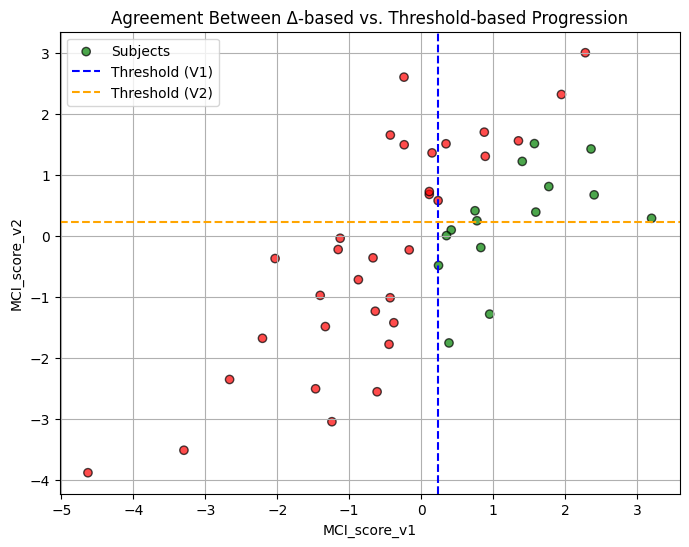

In [50]:
print("\n# 3.2.3 Comparison between Δ-based and Threshold-based Progression")

import matplotlib.pyplot as plt
import pandas as pd 

compare_df = df_longit.loc[
    df_longit['MCI_progression'].notna() & df_longit['MCI_progression_diag'].notna(),
    ['SubjectNumber','MCI_score_v1','MCI_score_v2','MCI_progression','MCI_progression_diag']
].copy()

compare_df['Agreement'] = (compare_df['MCI_progression'] == compare_df['MCI_progression_diag']).astype(int)
agreement_rate = 100.0 * compare_df['Agreement'].mean() if len(compare_df) > 0 else float('nan')

summary_comp = compare_df.groupby(['MCI_progression','MCI_progression_diag']).size().reset_index(name='Count')
display(summary_comp)

print(f"\nAgreement rate between Δ-based and diagnostic progression definitions: {agreement_rate:.1f}%")

if agreement_rate < 100:
    print("\nExamples of mismatched classifications:")
    display(compare_df.loc[compare_df['Agreement'] == 0].head(10))

# Scatterplot Visualization (Improved for visibility)

# Get rows with filled V1
plot_df1 = compare_df[['SubjectNumber',"MCI_score_v1","Agreement"]].dropna()
# Get rows with filled V2
plot_df2 = compare_df[["SubjectNumber","MCI_score_v2","Agreement"]].dropna()

# Merge the two DataFrames on 'SubjectNumber' using an 'inner' join
# Note: After merging, the Agreement columns will be 'Agreement_x' and 'Agreement_y'.
plot_df = pd.merge(
    plot_df1,
    plot_df2,
    on='SubjectNumber', 
    how='inner'
)


if len(plot_df) > 0:
    plt.figure(figsize=(8,6))
    
    # We use the Agreement_x column (Agreement_y also gives the same result)
    plt.scatter(
        plot_df['MCI_score_v1'], plot_df['MCI_score_v2'],
        c=plot_df['Agreement_x'].map({1:'green', 0:'red'}),
        alpha=0.7, 
        edgecolor='k', 
        label='Subjects'
    )
    
    plt.axvline(0.237787, color='blue', linestyle='--', label='Threshold (V1)')
    plt.axhline(0.237787, color='orange', linestyle='--', label='Threshold (V2)')
    plt.xlabel('MCI_score_v1')
    plt.ylabel('MCI_score_v2')
    plt.title('Agreement Between Δ-based vs. Threshold-based Progression')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("UYARI: MCI_score_v1 ve MCI_score_v2 skorlarının her ikisinin de geçerli olduğu satır bulunamadığı için dağılım grafiği (scatter plot) çizilemedi.")

### 3.2.4 Discussion on Comparison between Δ-based and Threshold-based Progression

The comparison reveals that the **agreement rate between Δ-based and diagnostic (threshold-based) progression** definitions is relatively low **(~30%)**.
This discrepancy is both expected and informative:

### 🔹 Conceptual Difference

* **Δ-based progression** detects *any measurable score change*, even small ones (e.g., +0.05).

  * Sensitive to subtle trends or early deterioration/improvement.
  * Ignores the absolute diagnostic boundary.
* **Threshold-based progression** only marks a transition when the score crosses the empirical diagnostic cutoff (0.2378).

  * Captures categorical diagnostic shifts (e.g., from non-MCI → MCI).
  * Ignores small variations within the same diagnostic region.

### 🔹 Practical Implications

* Many participants show small positive or negative changes that exceed ±0.01 (Δ-tolerance) yet remain on the same side of the threshold.

  * These cases are *progression* or *regression* by Δ-logic but *stable* diagnostically.
* Consequently, high disagreement arises in mild or borderline changes.

### 🔹 Interpretation

* The Δ-based metric is **more sensitive**, flagging early continuous variations.
* The threshold-based metric is **more specific**, flagging clinically meaningful transitions.
* Both are valuable but serve **different analytical purposes**:

  * Δ-based → useful for **monitoring subtle cognitive trends**.
  * Threshold-based → useful for **classifying diagnostic conversion**.

### 🔹 Visualization Insight

In the scatterplot:

* The dashed blue (x-axis) and orange (y-axis) lines represent the diagnostic cutoff.
* Points above both lines remain in the MCI region (stable high scores).
* Points below both remain healthy (stable low scores).
* Only those crossing between quadrants show true diagnostic conversion.
* Red points (disagreement) cluster near the threshold, where minor Δ-changes occur without class transition.

---

**Summary:**
The mismatch is expected because Δ-based analysis measures *continuous score dynamics*, while threshold-based analysis detects *categorical diagnostic changes*.
Both should be reported together for a complete understanding of cognitive progression behavior.


## 3.3 Summary Statistics and Interpretation

After adding the difference and progression attributes, compute simple summary counts and percentages:

- `total_pairs`: number of rows with both scores available
- counts and percentages for each progression class:
  - `progression (1)`: {count_progress} observations ({pct_progress:.1f}%)
  - `stable (0)`: {count_stable} observations ({pct_stable:.1f}%)
  - `regression/improvement (-1)`: {count_regress} observations ({pct_regress:.1f}%)

In [51]:
# 3.3 Summary Statistics and Interpretation (subject-level enhanced)
print("\n# 3.3 Summary Statistics and Interpretation (including subject-level view)")

# Count (row-level)
total_pairs = int(df_longit[diff_col].notna().sum())
count_progress = int((df_longit[prog_col] == 1).sum())
count_stable = int((df_longit[prog_col] == 0).sum())
count_regress = int((df_longit[prog_col] == -1).sum())

# Subject-level unique count (e.g., each subject once)
numOfSubjects = df_longit.loc[df_longit[diff_col].notna(), 'SubjectNumber'].nunique()

# --- Subject-level progression (based on unique subjects)
# For each subject, take last non-null progression value
subject_progress = (
    df_longit.loc[df_longit[diff_col].notna(), ['SubjectNumber', prog_col]]
    .dropna()
    .drop_duplicates(subset=['SubjectNumber'], keep='last')
)

n_subj_prog = int((subject_progress[prog_col] == 1).sum())
n_subj_stable = int((subject_progress[prog_col] == 0).sum())
n_subj_regress = int((subject_progress[prog_col] == -1).sum())

# Percentages (row-level)
pct_progress = 100.0 * count_progress / total_pairs if total_pairs > 0 else float('nan')
pct_stable = 100.0 * count_stable / total_pairs if total_pairs > 0 else float('nan')
pct_regress = 100.0 * count_regress / total_pairs if total_pairs > 0 else float('nan')

# Percentages (subject-level)
pct_subj_prog = 100.0 * n_subj_prog / numOfSubjects if numOfSubjects > 0 else float('nan')
pct_subj_stable = 100.0 * n_subj_stable / numOfSubjects if numOfSubjects > 0 else float('nan')
pct_subj_regress = 100.0 * n_subj_regress / numOfSubjects if numOfSubjects > 0 else float('nan')

# --- Tabular summary (both views)
summary_tbl = pd.DataFrame({
    'Progression_Category': [
        'Progression (1)',
        'Stable (0)',
        'Regression/Improvement (-1)',
        'Total'
    ],
    'Row-based Count': [count_progress, count_stable, count_regress, total_pairs],
    'Row-based %': [f"{pct_progress:.1f}%", f"{pct_stable:.1f}%", f"{pct_regress:.1f}%", "100%"],
    'Subject-based Count': [n_subj_prog, n_subj_stable, n_subj_regress, numOfSubjects],
    'Subject-based %': [f"{pct_subj_prog:.1f}%", f"{pct_subj_stable:.1f}%", f"{pct_subj_regress:.1f}%", "100%"]
})

display(summary_tbl)

# --- Interpretation text
print("\nInterpretation Summary:")
if total_pairs == 0:
    print("No paired MCI_score_v1/v2 data available for progression analysis.")
else:
    print(f"Out of {numOfSubjects} unique subjects (each having both V1 and V2 MCI scores):")
    print(f"• {n_subj_prog} ({pct_subj_prog:.1f}%) showed **progression** (MCI_score increased)")
    print(f"• {n_subj_regress} ({pct_subj_regress:.1f}%) showed **regression/improvement** (MCI_score decreased)")
    print(f"• {n_subj_stable} ({pct_subj_stable:.1f}%) remained **stable** (change ≤ ±{change_tol})")

    print(f"\n(Note: The table above also includes row-based counts for reference — "
          f"{total_pairs} total observations representing {numOfSubjects} subjects.)")



# 3.3 Summary Statistics and Interpretation (including subject-level view)


,Progression_Category,Row-based Count,Row-based %,Subject-based Count,Subject-based %
0,Progression (1),44,46.8%,22,46.8%
1,Stable (0),0,0.0%,0,0.0%
2,Regression/Improvement (-1),50,53.2%,25,53.2%
3,Total,94,100%,47,100%



Interpretation Summary:
Out of 47 unique subjects (each having both V1 and V2 MCI scores):
• 22 (46.8%) showed **progression** (MCI_score increased)
• 25 (53.2%) showed **regression/improvement** (MCI_score decreased)
• 0 (0.0%) remained **stable** (change ≤ ±0.01)

(Note: The table above also includes row-based counts for reference — 94 total observations representing 47 subjects.)


## 3.4 Progression Discussion

In the longitudinal dataset, a total of **47 unique subjects** were identified, each with both baseline (V1) and follow-up (V2) MCI scores available for comparison. The progression analysis revealed that **22 subjects (46.8%)** demonstrated a measurable **increase** in MCI score, indicating cognitive **progression or decline**, while **25 subjects (53.2%)** exhibited a **decrease** in their scores, suggesting **regression or cognitive improvement**. No subjects were classified as **stable**, as all observed score changes exceeded the defined tolerance threshold (±0.01).

These findings suggest a nearly balanced distribution between improvement and decline among the observed population, with a slight dominance of subjects showing regression (improvement). The absence of stability cases implies that the MCI score metric used here is highly sensitive to inter-visit changes. Further longitudinal evaluation with more visits or adjusted tolerance levels may provide deeper insights into intermediate or partially stable trajectories.

*Note:* The summary table in the previous section presents both row-based (94 total observations) and subject-based (47 total participants) statistics for clarity.
